Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 7.2 MB/s 
     |████████████████████████████████| 829 kB 17.6 MB/s 
     |████████████████████████████████| 118 kB 37.6 MB/s 
     |████████████████████████████████| 10.6 MB 30.6 MB/s 
     |████████████████████████████████| 636 kB 70.4 MB/s 
     |████████████████████████████████| 234 kB 76.0 MB/s 
     |████████████████████████████████| 1.3 MB 90.1 MB/s 
     |████████████████████████████████| 142 kB 74.3 MB/s 
     |████████████████████████████████| 294 kB 91.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 27
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = False

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'resnet'
BATCH_SIZE = 512
NUM_EPOCHS = 500

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp027'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 19:41:13,190 - __main__ - INFO - Experiment no: 27
2021-07-21 19:41:13,192 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 19:41:13,194 - __main__ - INFO - SEED: 1
2021-07-21 19:41:13,197 - __main__ - INFO - REGRESSION: False


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 19:41:13,211 - __main__ - DEBUG - Start loading csv files (0.007 seconds passed)
2021-07-21 19:41:14,428 - __main__ - DEBUG - Complete loading csv files (1.225 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 19:41:14,941 - __main__ - DEBUG - Start fold 1 (1.737 seconds passed)
2021-07-21 19:41:14,948 - __main__ - DEBUG - Start training model (1.744 seconds passed)
2021-07-21 19:41:21,378 - __main__ - DEBUG - Epoch 0/499
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-21 19:46:23,273 - __main__ - DEBUG - train Loss: 0.6660
2021-07-21 19:48:28,084 - __main__ - DEBUG - val Loss: 29.5672
2021-07-21 19:48:28,094 - __main__ - DEBUG - Epoch 1/499
2021-07-21 19:48:36,328 - __main__ - DEBUG - train Loss: 0.5293
2021-07-21 19:48:38,931 - __main__ - DEBUG - val Loss: 1.9881
2021-07-21 19:48:38,940 - __main__ - DEBUG - Epoch 2/499
20

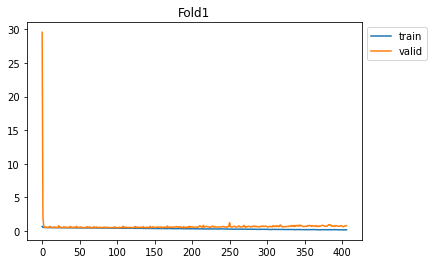

2021-07-21 21:03:35,504 - __main__ - DEBUG - Complete prediction for train fold (4942.301 seconds passed)
2021-07-21 21:03:38,174 - __main__ - DEBUG - Complete prediction for val fold (4944.970 seconds passed)
2021-07-21 21:09:45,391 - __main__ - DEBUG - Complete prediction for test fold (5312.187 seconds passed)
2021-07-21 21:09:45,420 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp027/cv_fold1_training.csv (5312.216 seconds passed)
2021-07-21 21:09:45,430 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp027/cv_fold1_validation.csv (5312.227 seconds passed)
2021-07-21 21:09:45,467 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp027/cv_fold1_test.csv (5312.263 seconds passed)
2021-07-21 21:09:45,603 - __main__ - DEBUG - Save model ../scripts/../experiments/exp027/cv_fold1_model.torch (5312.399 seconds passed)
2021-07-21 21:09:45,697 - __main__ - DEBUG - Complete fold 1 (5312.494 seconds passed)
2021-07-21 21:09:45,700

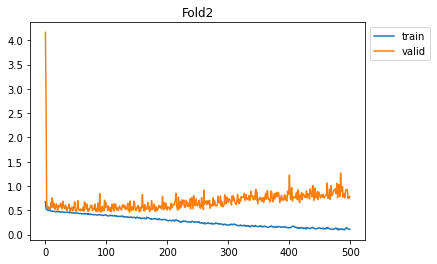

2021-07-21 22:42:28,120 - __main__ - DEBUG - Complete prediction for train fold (10874.916 seconds passed)
2021-07-21 22:42:30,708 - __main__ - DEBUG - Complete prediction for val fold (10877.505 seconds passed)
2021-07-21 22:42:41,415 - __main__ - DEBUG - Complete prediction for test fold (10888.212 seconds passed)
2021-07-21 22:42:41,443 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp027/cv_fold2_training.csv (10888.239 seconds passed)
2021-07-21 22:42:41,456 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp027/cv_fold2_validation.csv (10888.252 seconds passed)
2021-07-21 22:42:41,493 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp027/cv_fold2_test.csv (10888.289 seconds passed)
2021-07-21 22:42:41,631 - __main__ - DEBUG - Save model ../scripts/../experiments/exp027/cv_fold2_model.torch (10888.427 seconds passed)
2021-07-21 22:42:41,736 - __main__ - DEBUG - Complete fold 2 (10888.532 seconds passed)
2021-07-21 22:4

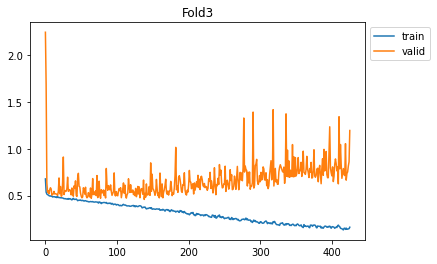

2021-07-22 00:02:02,088 - __main__ - DEBUG - Complete prediction for train fold (15648.884 seconds passed)
2021-07-22 00:02:04,826 - __main__ - DEBUG - Complete prediction for val fold (15651.622 seconds passed)
2021-07-22 00:02:16,108 - __main__ - DEBUG - Complete prediction for test fold (15662.904 seconds passed)
2021-07-22 00:02:16,136 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp027/cv_fold3_training.csv (15662.932 seconds passed)
2021-07-22 00:02:16,148 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp027/cv_fold3_validation.csv (15662.945 seconds passed)
2021-07-22 00:02:16,193 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp027/cv_fold3_test.csv (15662.990 seconds passed)
2021-07-22 00:02:16,345 - __main__ - DEBUG - Save model ../scripts/../experiments/exp027/cv_fold3_model.torch (15663.141 seconds passed)
2021-07-22 00:02:16,470 - __main__ - DEBUG - Complete fold 3 (15663.266 seconds passed)
2021-07-22 00:0

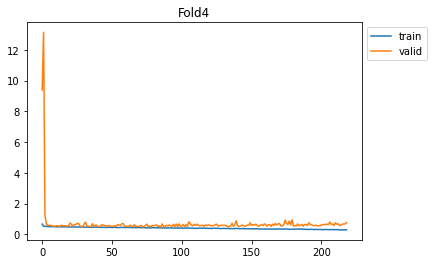

2021-07-22 00:43:26,630 - __main__ - DEBUG - Complete prediction for train fold (18133.426 seconds passed)
2021-07-22 00:43:29,393 - __main__ - DEBUG - Complete prediction for val fold (18136.189 seconds passed)
2021-07-22 00:43:39,973 - __main__ - DEBUG - Complete prediction for test fold (18146.769 seconds passed)
2021-07-22 00:43:40,006 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp027/cv_fold4_training.csv (18146.802 seconds passed)
2021-07-22 00:43:40,020 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp027/cv_fold4_validation.csv (18146.816 seconds passed)
2021-07-22 00:43:40,063 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp027/cv_fold4_test.csv (18146.859 seconds passed)
2021-07-22 00:43:40,220 - __main__ - DEBUG - Save model ../scripts/../experiments/exp027/cv_fold4_model.torch (18147.016 seconds passed)
2021-07-22 00:43:40,363 - __main__ - DEBUG - Complete fold 4 (18147.159 seconds passed)
2021-07-22 00:4

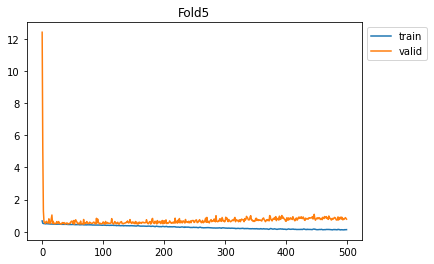

2021-07-22 02:17:57,113 - __main__ - DEBUG - Complete prediction for train fold (23803.909 seconds passed)
2021-07-22 02:17:59,962 - __main__ - DEBUG - Complete prediction for val fold (23806.758 seconds passed)
2021-07-22 02:18:11,334 - __main__ - DEBUG - Complete prediction for test fold (23818.130 seconds passed)
2021-07-22 02:18:11,364 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp027/cv_fold5_training.csv (23818.160 seconds passed)
2021-07-22 02:18:11,394 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp027/cv_fold5_validation.csv (23818.190 seconds passed)
2021-07-22 02:18:11,433 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp027/cv_fold5_test.csv (23818.229 seconds passed)
2021-07-22 02:18:11,574 - __main__ - DEBUG - Save model ../scripts/../experiments/exp027/cv_fold5_model.torch (23818.371 seconds passed)
2021-07-22 02:18:11,714 - __main__ - DEBUG - Complete fold 5 (23818.511 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    num_classes = len(set(list(y_train)))
    model, input_size = initialize_model(MODEL_NAME, num_classes)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    if not REGRESSION:
        # label should be one-hot style
        y_train = np.identity(num_classes)[y_train].astype('int')
        y_valid = np.identity(num_classes)[y_valid].astype('int')
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.BCEWithLogitsLoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    predictions = {}
    for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                  [train_object_ids, valid_object_ids, test['object_id']]):
        # Prepare transformer
        transformer_ = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Prepare dataset
        dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
        # Prepare dataloader
        dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=os.cpu_count())
        # Prediction
        predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
        logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                     .format(fold_, time.time() - SINCE))
    if REGRESSION:
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:
        columns = list(range(num_classes))
        pred_train = pd.DataFrame(data=predictions['train'], columns=columns)
        pred_valid = pd.DataFrame(data=predictions['val'], columns=columns)
        pred_test = pd.DataFrame(data=predictions['test'], columns=columns)
    # else:  # Do not come here!
    #     raise NotImplemented
        # try:
        #     pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
        #                               columns=estimator.classes_)
        #     pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
        #                               columns=estimator.classes_)
        #     pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
        #                              columns=estimator.classes_)
        # except AttributeError:
        #     pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
        #                               columns=estimator.classes_)
        #     pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
        #                               columns=estimator.classes_)
        #     pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
        #                              columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-22 02:18:11,765 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-22 02:18:11,805 - __main__ - DEBUG - Loss: 1.002067925536256
2021-07-22 02:18:11,806 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-22 02:18:11,838 - __main__ - DEBUG - Loss: 0.7936396960201898
2021-07-22 02:18:11,839 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-22 02:18:11,868 - __main__ - DEBUG - Loss: 0.8190223348612593
2021-07-22 02:18:11,869 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-22 02:18:11,900 - __main__ - DEBUG - Loss: 0.8886266709963703
2021-07-22 02:18:11,901 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-22 02:18:11,937 - __main__ - DEBUG - Loss: 0.8696857134347314


[[154  58  57 100]
 [ 65 260 226 163]
 [ 35 111 727 333]
 [ 17  38 135 661]]
[[203 110  24  47]
 [ 25 506 106  78]
 [ 24 189 835 167]
 [ 14  67  73 693]]
[[201 131  25  21]
 [ 38 541  82  46]
 [ 65 255 774 107]
 [ 39  79  98 645]]
[[184  92  56  50]
 [ 60 373 185  95]
 [ 52 147 853 185]
 [ 20  57 150 593]]
[[170 116  53  48]
 [ 33 446 158  98]
 [ 21 207 796 161]
 [ 16  79 126 620]]


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,0,1,2,3,actual,pred
object_id,,,,,,
002bff09b09998d0be65,-1.82865,0.56532,-1.41153,-2.49226,1,1
00309fb1ef05416f9c1f,-2.18618,-2.03751,-1.71509,0.86308,3,3
003a1562e97f79ba96dc,-2.61832,-2.12395,-1.91605,1.09322,3,3
004890880e8e7431147b,-0.96113,0.23149,-1.88404,-3.36808,2,1
00718c32602425f504c1,-3.07710,-2.74474,-1.78744,1.34980,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-3.74841,-2.36851,-1.92533,1.53704,3,3
ffd4d361756587883e48,-2.03057,1.40665,-2.00554,-3.69152,1,1
ffd794b7b311b7b7fd92,-3.57846,-2.84573,1.07896,-1.67122,2,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-22 02:18:12,035 - __main__ - INFO - Training loss: 0.7919136659096802


[[ 243  125   50   57]
 [  35  592  159  110]
 [  24  187 1090  210]
 [  15   60  129  851]]


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-22 02:18:12,072 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp027/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-22 02:18:12,098 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-22 02:18:12,113 - __main__ - DEBUG - Loss: 1.0198777204240295
2021-07-22 02:18:12,115 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-22 02:18:12,132 - __main__ - DEBUG - Loss: 0.9824490753046746
2021-07-22 02:18:12,134 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-22 02:18:12,147 - __main__ - DEBUG - Loss: 0.9209241368444986
2021-07-22 02:18:12,148 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-22 02:18:12,160 - __main__ - DEBUG - Loss: 1.0063492701359626
2021-07-22 02:18:12,161 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-22 02:18:12,175 - __main__ - DEBUG - Loss: 1.0213190109755006


[[ 38  23  21  24]
 [ 21  58  59  44]
 [ 11  34 188  72]
 [  4   7  36 157]]
[[ 36  29  10  16]
 [  9  94  45  33]
 [  8  61 175  52]
 [  7  28  30 143]]
[[ 49  33   9   6]
 [ 16 118  38  17]
 [ 11  84 161  54]
 [ 12  24  39 119]]
[[ 34  25  17  17]
 [ 16  72  67  28]
 [  9  52 149  64]
 [  6  23  56 150]]
[[ 27  25  19  17]
 [ 12  79  49  21]
 [ 11  71 185  59]
 [ 10  24  64 116]]


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,0,1,2,3,actual,pred
object_id,,,,,,
002bff09b09998d0be65,-0.01399,0.02342,-0.64300,-1.15144,1,1
00309fb1ef05416f9c1f,-0.63452,-0.61016,-0.43848,0.19920,3,3
003a1562e97f79ba96dc,-1.36020,-0.92068,-0.63498,0.61640,3,3
004890880e8e7431147b,-0.09372,-0.04708,-0.42211,-0.84941,2,1
00718c32602425f504c1,-1.16362,-0.75606,-0.46679,0.45129,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-0.40018,-0.36380,-0.33251,0.12285,3,3
ffd4d361756587883e48,-0.49401,0.26913,-0.39679,-0.83062,1,1
ffd794b7b311b7b7fd92,-0.69002,-0.55044,-0.02790,-0.00756,2,3


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-22 02:18:12,250 - __main__ - INFO - Validatino loss: 0.9909419579026452


[[184 135  76  80]
 [ 74 421 258 143]
 [ 50 302 858 301]
 [ 39 106 225 685]]


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-22 02:18:12,286 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp027/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-22 02:18:12,298 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp027/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,0,1,2,3,pred
object_id,,,,,
0009e50b94be36ccad39,-2.64847,0.17996,-1.33991,-2.81825,1
000bd5e82eb22f199f44,-2.45541,-1.24951,-0.97889,-0.74965,3
0015f44de1854f617516,-4.67676,-1.63994,1.45417,-4.06138,2
00388a678879ba1efa27,-4.48296,-2.19267,-0.60149,-0.24440,3
005e1e7c6496902d23f3,-0.69331,0.16331,-2.31902,-3.92515,1
...,...,...,...,...,...
ffbe65ad399b632dcbd0,-3.19813,-2.92484,-1.77744,1.21438,3
ffd7b2d646c0320c311a,-3.30352,2.79408,-3.36934,-6.23924,1
ffdb93ede17d4501e530,-2.48016,-1.67098,0.59985,-3.19279,2


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1
1,3
2,2
3,3
4,1
...,...
5914,3
5915,1
5916,2
5917,2


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-22 02:18:12,474 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp027/027_submission.csv


2021-07-22 02:18:12,544 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp027/prediction.png


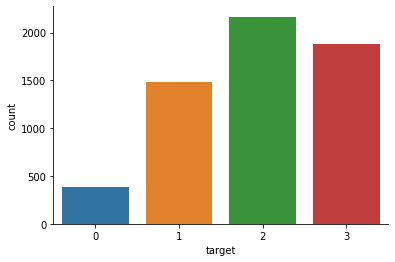

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 02:18:12,639 - __main__ - DEBUG - Complete (23819.435 seconds passed)
